In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
#import maxflow
import gco
import matplotlib.pyplot as plt
import matplotlib.colors as col
import numpy as np
from scipy.sparse import csr_matrix
import scipy.cluster as cluster
import sys
np.set_printoptions(threshold=5)#sys.maxsize)

import sklearn.mixture as mixture
# NOTE: THIS IS A PURE NUMPY PROBLEM.

# you will need to include some libraries depending on your needs
# e.g. scipy.signal
# e.g. scipy.cluster
# e.g. scipy.spatial
# e.g. sklearn.mixture.GaussianMixture
# ..

In [2]:
def edges4connected(height, width):
    """ Construct edges for 4-connected neighborhood MRF. Assume row-major ordering.

      Args:
        height of MRF.
        width of MRF.

      Returns:
        A `nd.array` with dtype `int32/int64` of size |E| x 2.
    """

    # construct a matrix filled with indices
    npixels = height * width
    idx = np.arange(npixels).reshape(height, width)
    # horizontal edges
    hedges = np.hstack((idx[:, :-1].reshape((-1, 1)), idx[:, 1:].reshape((-1, 1))))
    # vertical edges
    vedges = np.hstack((idx[:-1, :].reshape((-1, 1)), idx[1:, :].reshape((-1, 1))))
    # stack
    edges = np.vstack((hedges, vedges))

    # sanity check
    assert (edges.shape[0] == 2 * (height*width) - (height+width) and edges.shape[1] == 2)
    assert (edges.dtype in [np.int32, np.int64])
    return edges

In [3]:
def cluster_coarse_color_statistics(smoothed, num_segments):
    """ Performs initial clustering of color statistics of (smoothed) input

      Args:
        smoothed            input image
        num_segments        number of clusters

      Returns:
        initial labels in {0, ..., NUM_LABELS-1} of size MxN
    """
    im=smoothed
    im_arr=im.reshape(im.shape[0]*im.shape[1],im.shape[2])
    
   
    centroids, label=cluster.vq.kmeans2(im_arr,3)
    label= label.reshape((im.shape[0],im.shape[1]))
    assert (label.ndim == 2 and np.equal(label.shape, smoothed.shape[0:2]).all())
    assert (label.dtype in [np.int32, np.int64])
    return label

In [4]:
def label2color(im, label):
    """ Returns a color-coding of labels superimposed on input image

      Args:
        im          input image of size MxNx3
        label       pixelwise labels in {0, ..., NUM_LABELS-1} of size MxN

      Returns:
        Color-coded labels
    """
    
    im_hsv=col.rgb_to_hsv(im)
    im_hsv[:,:,0] = label/2#max(label.reshape(label.shape[0]*label.shape[1]))
    colored = col.hsv_to_rgb(im_hsv)

    assert (np.equal(colored.shape, im.shape).all())
    assert (im.dtype == colored.dtype)
    return colored

In [5]:
def contrast_weight(im, edges):
    """ Computes the weight vector W for the contrast-sensitive Potts model:
        For each pairwise potential e connecting pixels i with j compute
        w(e) = exp(- beta*||I(i) - I(j)||_2^2), where beta is the mean
        squared distance between the intensity values of neighboring pixels.

      Args:
        im           input image
        edges        edge map

      Returns:
        Contrast sensitive weights for every edge
    """
    im_array= im.reshape(3,im.shape[0]*im.shape[1])
    weights=np.zeros(edges.shape[0])

    #squared distance between pixel color of neighbouring pixels
    for i,e in enumerate(edges,0):
        znR,zmR=im_array[0][e]
        znG,zmG=im_array[1][e]
        znB,zmB=im_array[2][e]
        # squared difference between the neighbouring pixels, according to original paper
        weights[i]=((znR-zmR)**2+(znB-zmB)**2+(znG-zmG)**2)
        
        
    #weights are already squared so they already comply to the euclidean norm
    beta= 1.0/(sum(weights)/edges.shape[0])
        
    

    cweights = np.array(list(map(lambda x: np.exp(-beta*x), weights)))

    # sanity check
    assert (len(cweights[:]) == edges.shape[0])
    return cweights

In [6]:
def make_pairwise(lmbda, edges, cweights, num_sites):
    """ Make pairwise capacity matrix for contrast-sensitive Potts model """
    
    #lmbda is the parameter gamme from the paper? Hence it's multiplied with the weights
    data= cweights*lmbda
    row=edges[:,0]
    col=edges[:,1]
    # Initialise the pairwise csr matrix directly 
    # Use standard Potts model (with lambda) for pairwise potentials
    pairwise=csr_matrix((data, (row, col)), shape=(num_sites, num_sites),dtype=np.float64)  
    

    assert (isinstance(pairwise, csr_matrix))
    assert (np.equal(pairwise.shape, (num_sites, num_sites)).all())
    return pairwise

In [8]:
def negative_logprob_gmm(im, label, gmm_components, num_segments):
    """ Fits and evaluates Gaussian mixture models on segments

      Args:
        im                  input image
        label               current labels
        gmm_components      number of mixture model components
        num_segments        total number of segments

      Returns:
        nllh negative log probabilities for all pixels
    """
    im_flat = im.reshape((im.shape[0]*im.shape[1],im.shape[2]))
    nllh=np.zeros((num_segments, label.shape[0]*label.shape[1]))
    for i in np.arange(num_segments):    
        
        segment_i = im.reshape((im.shape[0]*im.shape[1],im.shape[2]))[label.reshape(im.shape[0]*im.shape[1])==i]
        
        gmm = mixture.GaussianMixture(n_components=gmm_components)
        gmm=gmm.fit(segment_i)
        #score_samples returns positive logprobs
        nllh[i,:]= gmm.score_samples(im_flat)*-1
    
    assert (np.equal(nllh.shape, (num_segments, label.shape[0]*label.shape[1])).all())
    return nllh

In [9]:
def expand_alpha(alpha, im, label, pairwise, gmm_components, num_segments):
    """ Perform single step of alpha-expansion

      Args:
        alpha               current label to expand
        im                  input image
        label               current labels
        pairwise            pairwise capacity matrix
        gmm_components      number of mixture model components
        num_segments        total number of segments

      Returns:
        label mask (with alpha having been expanded)
    """
    
     
        
    
    label_flat=label.reshape(1,label.shape[0]*label.shape[1])   
    nllh=negative_logprob_gmm(im,label,gmm_components,num_segments)      
    stack=np.vstack((label_flat,nllh))  
    
    
    unaries_current=np.array([pixel[int(pixel[0])+1] for pixel in stack.T])
    unaries_proposed=nllh[alpha]  
    
    
    unaries=np.vstack((unaries_current,unaries_proposed))
    print(unaries.shape)
    cut=gco.graphcut(unaries,pairwise).reshape(label.shape)
    
    
    
    print("cut"+ str(np.nonzero(cut)[0].shape))
    #construct new label matrix
    updated_label = alpha*cut
    updated_label+= label*(-1*(cut-1))
    print("Label diff")
    print(np.nonzero(updated_label-label)[0].shape)
    plt.imshow(np.abs(updated_label-label))
    plt.show()
    

    # you should call negative_logprob_gmm eventually...

    assert (np.equal(updated_label.shape, label.shape).all())
    assert (updated_label.dtype == label.dtype)
    return updated_label

In [24]:
def iterated_graphcuts(im, label0, pairwise, gmm_components, num_segments):
    """ Performs multi-label iterated graph cuts segmentation

      Args:
        im                  input image
        label0              initial labels
        pairwise            pairwise capacity matrix
        gmm_components      number of mixture model components
        num_segments        total number of segments

      Returns:
        final label mask
    """
    
    label = label0.copy()
    plt.imshow(label)
    plt.show()
    alphas=np.random.permutation(np.arange(num_segments))
    for i in np.arange(20):
        print("Iter:"+str(i))
        old_label= label.copy()
        
        for alpha in alphas:
            #label_old= label.copy()
            label= expand_alpha(alpha,im,label,pairwise,gmm_components,num_segments).copy()
        plt.imshow(label)
        plt.show()
        
        
        
        plt.imsave(os.path.join(os.getcwd(), 'bin','iter_'+str(i)+'_.png'), label2color(im, label))
        print(np.nonzero(old_label-label)[0].shape[0])
        if np.nonzero(old_label-label)[0].shape[0] < 40:
            break
                
    
    # you should call expand_alpha eventually...

    assert (label.ndim == 2 and np.equal(label.shape, label0.shape[0:2]).all())
    assert (label.dtype in [np.int32, np.int64])
    return label

In [16]:
def problem1():
    np.random.seed(846565)
    # Find some good settings: Keep it simple!
    num_segments = 3
    gmm_components = 5  # Find a good parameter
    lmbda = 1.5  # Find a good parameter

    # Read input image
    im = plt.imread('elk.png')

    # Cluster color statistics: Yields coarse estimate
    # (This part can be extended to give a better initialization)
    label0 = cluster_coarse_color_statistics(im, num_segments=num_segments) 

    # Write initial labeling
    if not os.path.isdir(os.path.join(os.getcwd(), 'bin')):
        os.mkdir(os.path.join(os.getcwd(), 'bin'))
        
    plt.imshow(label2color(im, label0*0.8)) #The 0.8 are just for better color visibility
    plt.imsave(os.path.join(os.getcwd(), 'bin', 'init.png'), label2color(im, label0))

    # Contrast sensitive Potts model
    edges = edges4connected(im.shape[0], im.shape[1])
    cweights = contrast_weight(im, edges)
    pairwise = make_pairwise(lmbda, edges, cweights, im.shape[0]*im.shape[1])

    # Perform multi-label graph cuts segmentation
    iterated_graphcuts(im, label0, pairwise, gmm_components, num_segments)

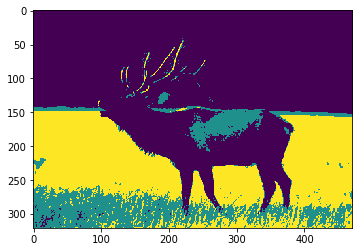

Iter:0
(2, 151191)
cut(47,)
Label diff
(24,)


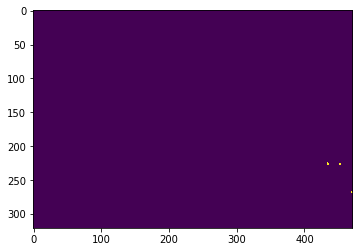

(2, 151191)
cut(3765,)
Label diff
(512,)


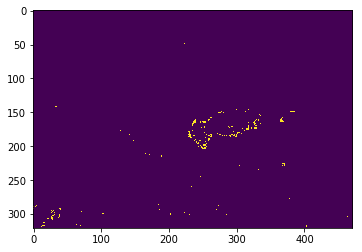

(2, 151191)
cut(8,)
Label diff
(4,)


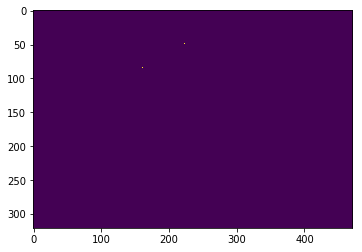

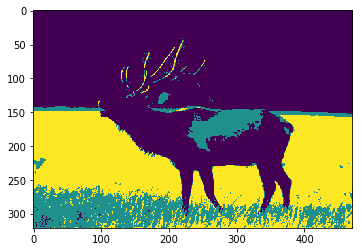

536
Iter:1
(2, 151191)
cut(0,)
Label diff
(0,)


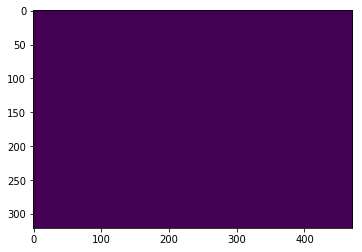

(2, 151191)
cut(4594,)
Label diff
(1181,)


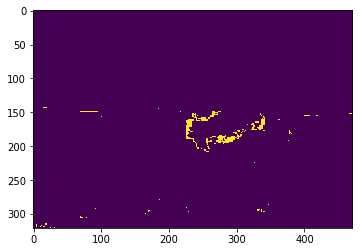

(2, 151191)
cut(6,)
Label diff
(1,)


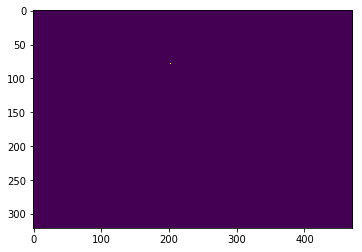

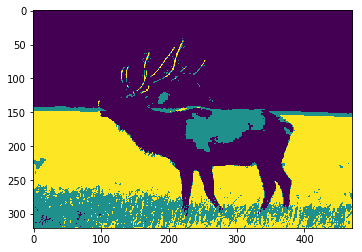

1182
Iter:2
(2, 151191)
cut(0,)
Label diff
(0,)


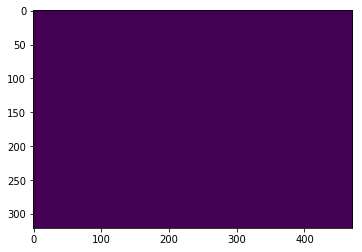

(2, 151191)
cut(6756,)
Label diff
(1169,)


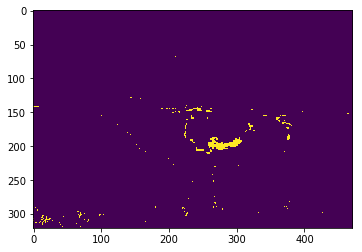

(2, 151191)
cut(0,)
Label diff
(0,)


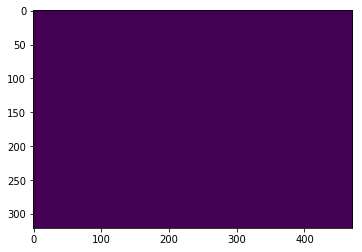

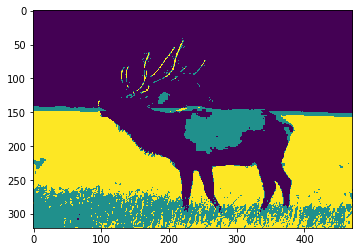

1169
Iter:3
(2, 151191)
cut(1,)
Label diff
(1,)


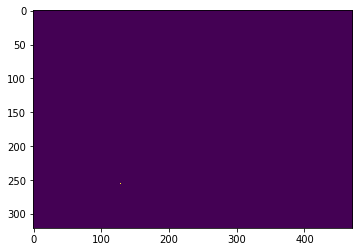

(2, 151191)
cut(6417,)
Label diff
(1066,)


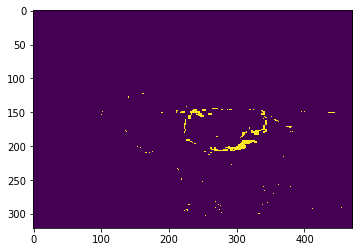

(2, 151191)
cut(30,)
Label diff
(16,)


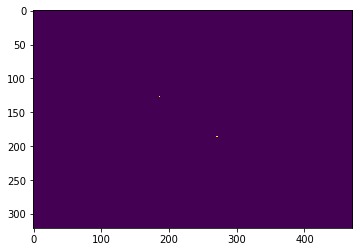

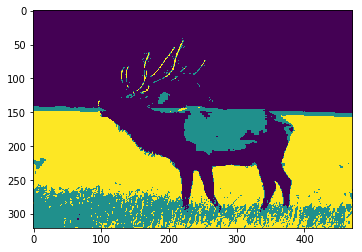

1075
Iter:4
(2, 151191)
cut(202,)
Label diff
(53,)


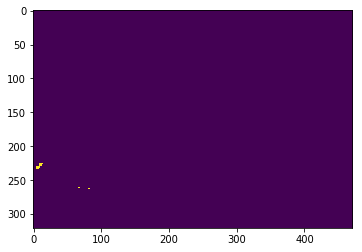

(2, 151191)
cut(2127,)
Label diff
(1032,)


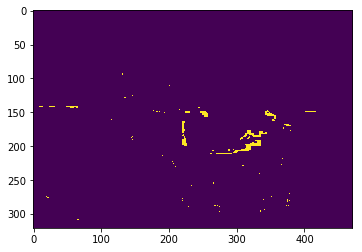

(2, 151191)
cut(0,)
Label diff
(0,)


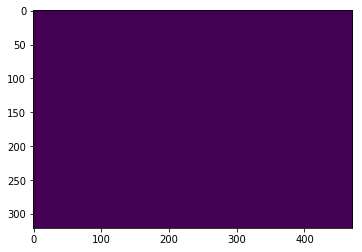

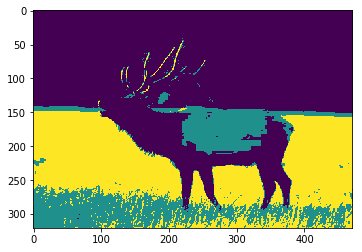

1085
Iter:5
(2, 151191)
cut(46,)
Label diff
(21,)


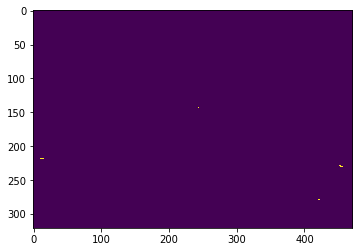

(2, 151191)
cut(6018,)
Label diff
(617,)


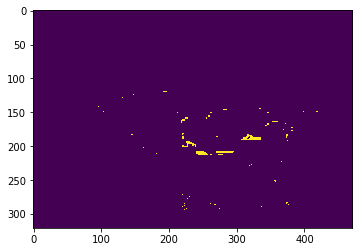

(2, 151191)
cut(2,)
Label diff
(2,)


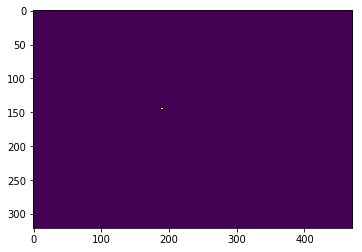

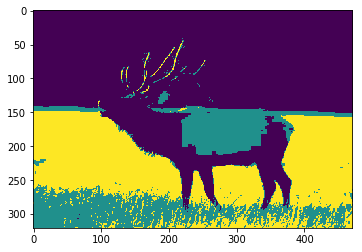

640
Iter:6
(2, 151191)
cut(880,)
Label diff
(77,)


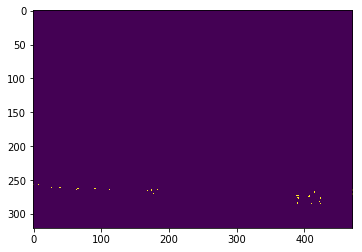

(2, 151191)
cut(265,)
Label diff
(209,)


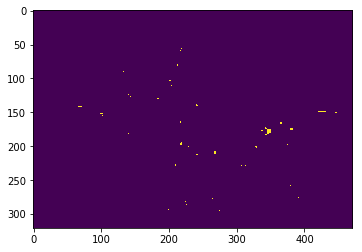

(2, 151191)
cut(12,)
Label diff
(3,)


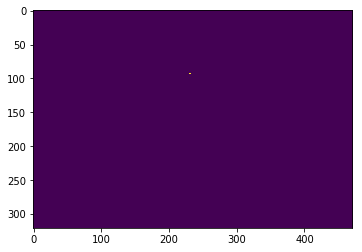

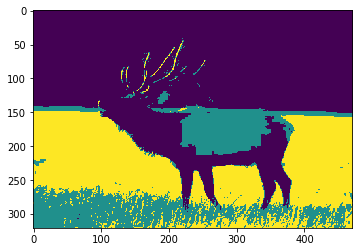

287
Iter:7
(2, 151191)
cut(42,)
Label diff
(26,)


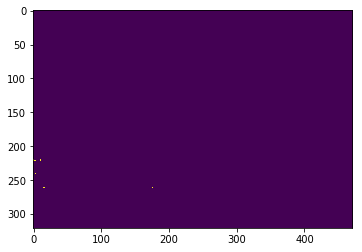

(2, 151191)
cut(148,)
Label diff
(99,)


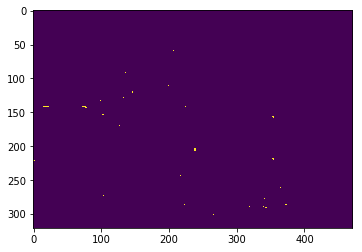

(2, 151191)
cut(6,)
Label diff
(1,)


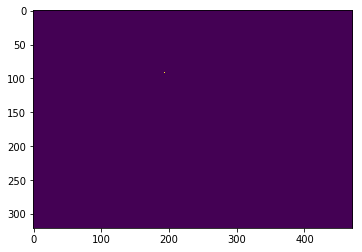

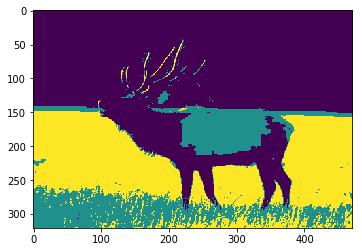

110
Iter:8
(2, 151191)
cut(36,)
Label diff
(12,)


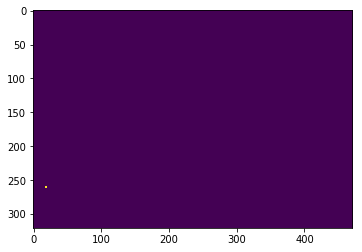

(2, 151191)
cut(349,)
Label diff
(211,)


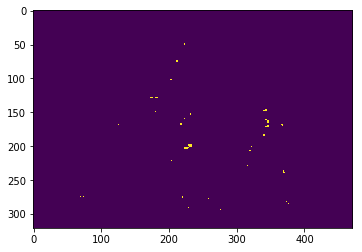

(2, 151191)
cut(2,)
Label diff
(2,)


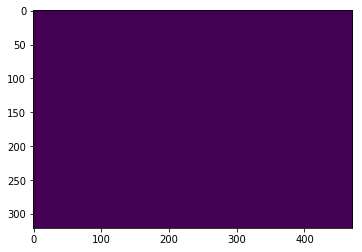

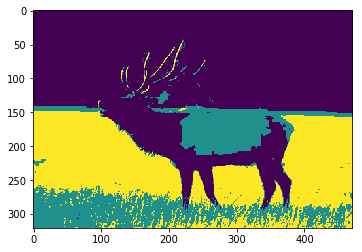

225
Iter:9
(2, 151191)
cut(0,)
Label diff
(0,)


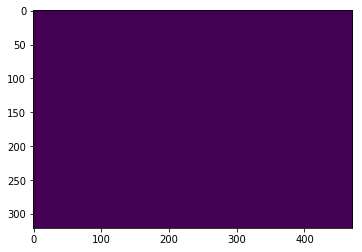

(2, 151191)
cut(205,)
Label diff
(140,)


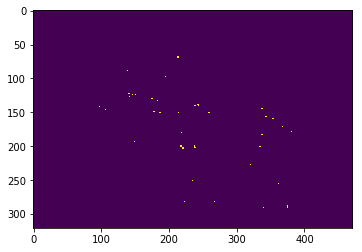

(2, 151191)
cut(0,)
Label diff
(0,)


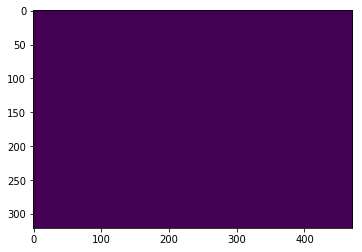

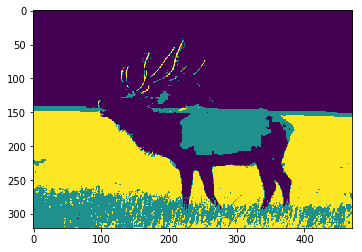

140
Iter:10
(2, 151191)
cut(6,)
Label diff
(6,)


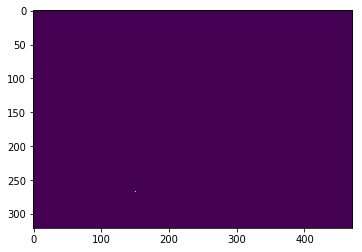

(2, 151191)
cut(77,)
Label diff
(67,)


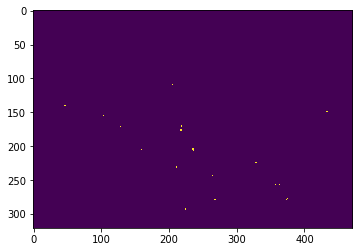

(2, 151191)
cut(3,)
Label diff
(3,)


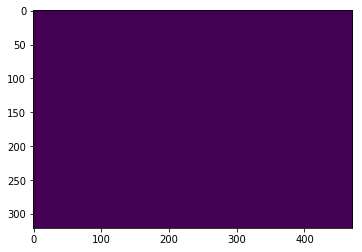

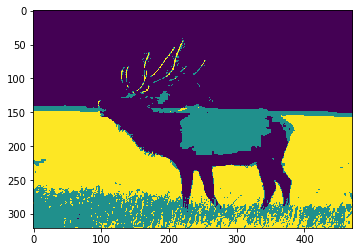

76
Iter:11
(2, 151191)
cut(26,)
Label diff
(12,)


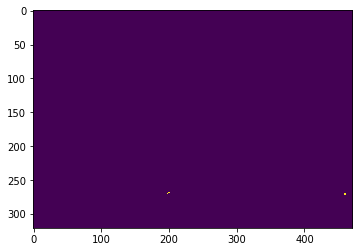

(2, 151191)
cut(68,)
Label diff
(53,)


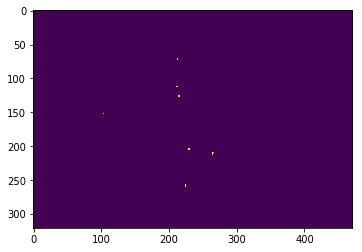

(2, 151191)
cut(0,)
Label diff
(0,)


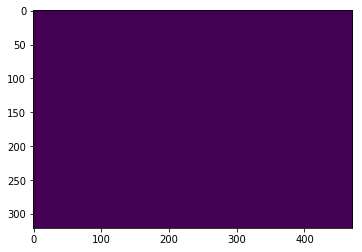

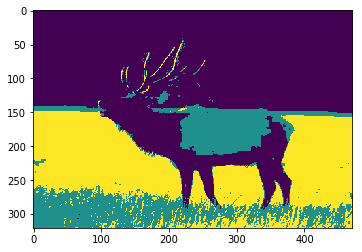

65
Iter:12
(2, 151191)
cut(35,)
Label diff
(21,)


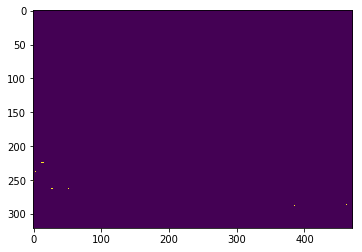

(2, 151191)
cut(116,)
Label diff
(72,)


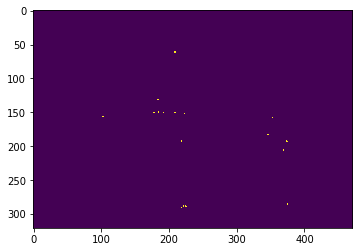

(2, 151191)
cut(0,)
Label diff
(0,)


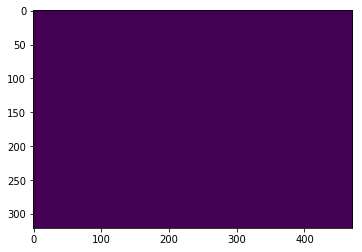

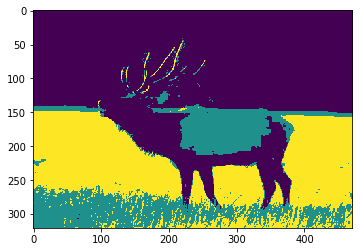

93
Iter:13
(2, 151191)
cut(2,)
Label diff
(2,)


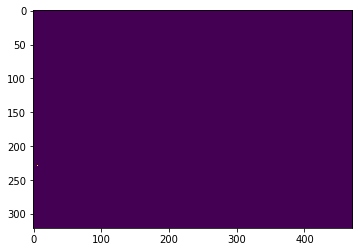

(2, 151191)
cut(40,)
Label diff
(35,)


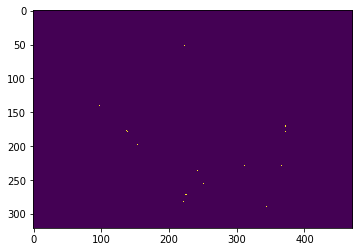

(2, 151191)
cut(0,)
Label diff
(0,)


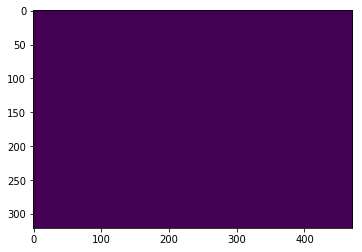

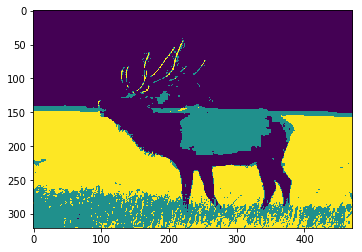

37


In [25]:
problem1()